# Time Series Classification using Convolutional Neural Networks in PyTorch


In [2]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder / Windows (No GPU)
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Linux / Windows (GPU)
# pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
 
# MacOS (NO GPU)
# !pip install numpy matplotlib torch torchvision torchaudio
# !pip install yfinance

     |████████████████████████████████| 6.3 MB 7.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=95a1de6333e55d39b3206b3e83031864dc097a7aa66e873567452d8ffde3eaba
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [1]:
import numpy as np
import torch
import yfinance as yf

In [2]:
project_name='time_series_classification_cnn'

We'll download the stock prices from yfinance

In [3]:
# Dowload the dataset
def get_data( name: str ):
  data = yf.download(name, start="2020-01-01", end="2021-01-01", interval = "1d")
  close_price = np.array(data['Close'])
  return close_price

In [4]:
# Download data
train_name = ['WM', 'NOC', 'XOM', 'V', 'BAC'] 
test_name = ['RSG', 'LMT', 'CVX', 'MA', 'JPM']
train_prices = []
test_prices = []
for name in train_name:
  train_prices.append(get_data(name)[0:250])
for name in test_name:
  test_prices.append(get_data(name)[0:250])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# Convert data to nparray
train_prices = np.array(train_prices)
test_prices = np.array(test_prices)

# Define a fillna function
def fillna(prices):
  # Obtain mean of columns as you need, nanmean is convenient.
  row_mean = np.nanmean(prices, axis=1)
  # Find indices that you need to replace
  inds = np.where(np.isnan(prices))
  # Place column means in the indices. 
  prices[inds] = np.take(row_mean, inds[0])
  return prices

# Fillna
train_prices = fillna(train_prices)
test_prices = fillna(test_prices)

In [6]:
train_prices = train_prices.reshape((5, 1, 250))
test_prices = test_prices.reshape((5, 1, 250))

Labelling

In [7]:
# transfer ndarray to tensor
train_prices = torch.from_numpy(train_prices).type(torch.float32)
test_prices = torch.from_numpy(test_prices).type(torch.float32)

In [8]:
train_prices.shape

torch.Size([5, 1, 250])

In [9]:
# label train data
train_dataset = []
for i in range(5):
  train_dataset.append((train_prices[i], i))

# label test data
test_dataset = []
for i in range(5):
  test_dataset.append((test_prices[i], i))

In [10]:
price, label = train_dataset[0]
print(price.shape, label)

torch.Size([1, 250]) 0


In [11]:
import matplotlib.pyplot as plt

Label (numeric): 0


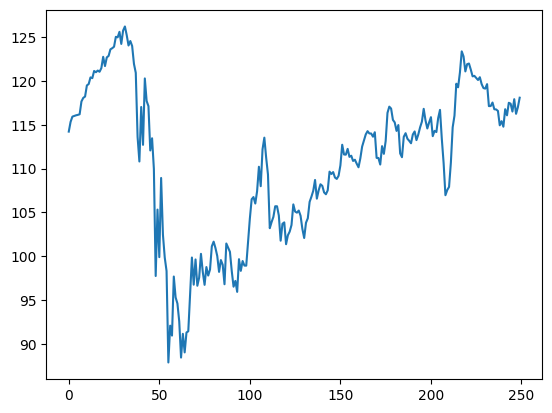

In [12]:
price, label = train_dataset[0]
plt.plot(np.arange(250), price[0])
print('Label (numeric):', label)

### Save and upload your notebook

Whether you're running this Jupyter notebook online or on your computer, it's essential to save your work from time to time. You can continue working on a saved notebook later or share it with friends and colleagues to let them execute your code. [Jovian](https://jovian.ai/platform-features) offers an easy way of saving and sharing your Jupyter notebooks online.

In [15]:
!pip install jovian --upgrade -q

In [16]:
# import jovian

In [ ]:
# jovian.commit(project=project_name)

## Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Since there's no predefined validation set, we can set aside a small portion of the training set to be used as the validation set. We'll use the `random_split` helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

In [13]:
random_seed = 15
torch.manual_seed(random_seed);

We can now create data loaders for training and validation, to load the data in batches

In [14]:
from torch.utils.data.dataloader import DataLoader
batch_size=1

In [15]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

In [18]:
for price, label in train_dl:
  print(price.shape, label)
  break

torch.Size([1, 1, 250]) tensor([0])


In [19]:
# jovian.commit(project=project_name, environment=None)

## Defining the Model (Convolutional Neural Network)

We will use a convolutional neural network, using the `nn.Conv1d` class from PyTorch.

In [20]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:

simple_model = nn.Sequential(
    nn.Conv1d(1, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool1d(2)
)

In [ ]:
for prices, labels in train_dl:
    print(prices.shape)
    output = simple_model(prices)
    print(output.shape)
    break

In [26]:
class ClassificationBase(nn.Module):
    def training_step(self, batch):
        prices, labels = batch 
        out = self(prices)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        prices, labels = batch 
        out = self(prices)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture.

In [27]:
class TimeSeriesCnnModel(ClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2), # output: 64 x 125

            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2), # output: 128 x 62

            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2), # output: 256 x 31

            nn.Flatten(), 
            nn.Linear(256*31, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
        
    def forward(self, xb):
        return self.network(xb)

In [28]:
model = TimeSeriesCnnModel()
model

TimeSeriesCnnModel(
  (network): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): ReLU()
    (7): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (8): ReLU()
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (11): ReLU()
    (12): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): ReLU()
    (14): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=7936, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features=512, bias

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. These are described in more detail in the [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn#C21).

In [29]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [30]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [31]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

Once again, let's save and commit the notebook before we proceed further.

In [32]:
# jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/ningboming/time-series-classification-cnn


'https://jovian.ai/ningboming/time-series-classification-cnn'

## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set. For a detailed walkthrough of these functions, check out the [previous tutorial](https://jovian.ai/aakashns/03-logistic-regression).

In [33]:
# Check the initial model 
for prices, labels in train_dl:
    out = model(prices)
    _, preds = torch.max(out, dim=1)
    print(preds, labels)

tensor([3], device='cuda:0') tensor([3], device='cuda:0')
tensor([3], device='cuda:0') tensor([1], device='cuda:0')
tensor([3], device='cuda:0') tensor([0], device='cuda:0')
tensor([2], device='cuda:0') tensor([4], device='cuda:0')
tensor([2], device='cuda:0') tensor([2], device='cuda:0')


In [35]:
for prices, labels in test_dl:
    out = model(prices)
    _, preds = torch.max(out, dim=1)
    print(preds, labels)

tensor([3], device='cuda:0') tensor([0], device='cuda:0')
tensor([3], device='cuda:0') tensor([1], device='cuda:0')
tensor([3], device='cuda:0') tensor([2], device='cuda:0')
tensor([3], device='cuda:0') tensor([3], device='cuda:0')
tensor([3], device='cuda:0') tensor([4], device='cuda:0')


In [36]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we begin training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [37]:
evaluate(model, test_dl)

{'val_acc': 0.20000000298023224, 'val_loss': 1.5874382257461548}

In [40]:
evaluate(model, train_dl)

{'val_acc': 0.4000000059604645, 'val_loss': 1.5940901041030884}

The initial accuracy is around 20%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We'll use the following *hyperparmeters* (learning rate, no. of epochs, batch_size etc.) to train our model. As an exercise, you can try changing these to see if you have achieve a higher accuracy in a shorter time. 

In [41]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.0001

It's important to record the hyperparameters of every experiment you do, to replicate it later and compare it against other experiments. We can record them using `jovian.log_hyperparams`.

In [42]:
# jovian.reset()
# jovian.log_hyperparams({
#     'num_epochs': num_epochs,
#     'opt_func': opt_func.__name__,
#     'batch_size': batch_size,
#     'lr': lr,
# })

[jovian] Hyperparams logged.


In [43]:
history = fit(num_epochs, lr, model, train_dl, test_dl, opt_func)

Epoch [0], train_loss: 1.8401, val_loss: 1.5814, val_acc: 0.2000
Epoch [1], train_loss: 1.5653, val_loss: 1.5090, val_acc: 0.2000
Epoch [2], train_loss: 1.5084, val_loss: 1.5130, val_acc: 0.2000
Epoch [3], train_loss: 1.4591, val_loss: 1.5031, val_acc: 0.2000
Epoch [4], train_loss: 1.4410, val_loss: 1.5579, val_acc: 0.2000
Epoch [5], train_loss: 1.4130, val_loss: 1.5542, val_acc: 0.2000
Epoch [6], train_loss: 1.4153, val_loss: 1.5650, val_acc: 0.2000
Epoch [7], train_loss: 1.3939, val_loss: 1.5343, val_acc: 0.2000
Epoch [8], train_loss: 1.4051, val_loss: 1.5210, val_acc: 0.2000
Epoch [9], train_loss: 1.4110, val_loss: 1.5227, val_acc: 0.2000
Epoch [10], train_loss: 1.4010, val_loss: 1.5165, val_acc: 0.2000
Epoch [11], train_loss: 1.3868, val_loss: 1.5590, val_acc: 0.2000
Epoch [12], train_loss: 1.3807, val_loss: 1.5577, val_acc: 0.2000
Epoch [13], train_loss: 1.4098, val_loss: 1.6620, val_acc: 0.2000
Epoch [14], train_loss: 1.3836, val_loss: 1.5548, val_acc: 0.2000
Epoch [15], train_lo

In [44]:
# Check the trained model
for prices, labels in train_dl:
    out = model(prices)
    _, preds = torch.max(out, dim=1)
    print(preds, labels)

tensor([1], device='cuda:0') tensor([1], device='cuda:0')
tensor([1], device='cuda:0') tensor([2], device='cuda:0')
tensor([1], device='cuda:0') tensor([3], device='cuda:0')
tensor([1], device='cuda:0') tensor([4], device='cuda:0')
tensor([1], device='cuda:0') tensor([0], device='cuda:0')


In [45]:
for prices, labels in test_dl:
    out = model(prices)
    _, preds = torch.max(out, dim=1)
    print(preds, labels)

tensor([1], device='cuda:0') tensor([0], device='cuda:0')
tensor([1], device='cuda:0') tensor([1], device='cuda:0')
tensor([1], device='cuda:0') tensor([2], device='cuda:0')
tensor([1], device='cuda:0') tensor([3], device='cuda:0')
tensor([1], device='cuda:0') tensor([4], device='cuda:0')


In [ ]:
# jovian.commit(project=project_name)